<H1> THIS VERSION IMPLEMENTS THE USE OF PI (HESITANCY DEGREE) </H1>

In [323]:
import numpy as np

def compute_ifahp_weights(if_matrix):
    """
    Compute IFAHP weights using the methodology from the research paper.
    if_matrix: List of (membership μ, non-membership ν) tuples.
    Returns: Normalized priority weights.
    """
    # Step 1: Extract membership (μ), non-membership (ν), and hesitancy (π) values
    mu = np.array([x[0] for x in if_matrix])  # Membership degrees
    nu = np.array([x[1] for x in if_matrix])  # Non-membership degrees
    pi = 1 - mu - nu  # Hesitancy degrees

    # Step 2: Transform IFPR into interval-valued preference relation
    lower_bound = mu  # Lower bound of interval
    upper_bound = 1 - nu  # Upper bound of interval

    # Step 3: Calculate priority weights using normalizing rank summation method
    sum_lower = np.sum(lower_bound)
    sum_upper = np.sum(upper_bound)
    
    weights = []
    for i in range(len(if_matrix)):
        weight_lower = (lower_bound[i] * (1 - pi[i])) / sum_upper  # Incorporate hesitancy
        weight_upper = (upper_bound[i] * (1 - pi[i])) / sum_lower  # Incorporate hesitancy
        weights.append((weight_lower, weight_upper))

    # Step 4: Normalize the weights
    total_weight_lower = sum([w[0] for w in weights])
    total_weight_upper = sum([w[1] for w in weights])
    
    normalized_weights = []
    for w in weights:
        normalized_lower = w[0] / total_weight_lower
        normalized_upper = w[1] / total_weight_upper
        normalized_weights.append((normalized_lower, normalized_upper))

    # Step 5: Return the normalized weights
    return normalized_weights

def check_consistency(if_matrix):
    """
    Check the consistency of the intuitionistic preference relation (IFPR).
    if_matrix: List of (membership μ, non-membership ν) tuples.
    Returns: Consistency ratio (CR).
    """
    # Step 1: Extract μ, ν, and π
    mu = np.array([x[0] for x in if_matrix])
    nu = np.array([x[1] for x in if_matrix])
    pi = 1 - mu - nu  # Hesitancy degrees

    # Step 2: Calculate the distance between the given IFPR and its perfect consistent version
    # Include π in the distance measure
    distance = np.sum(np.abs(mu - nu) + np.abs(pi)) / (2 * len(if_matrix) * (len(if_matrix) - 1))
    
    # Step 3: Compare with the consistency threshold (τ = 0.1)
    consistency_threshold = 0.1
    if distance < consistency_threshold:
        return True, distance  # IFPR is consistent
    else:
        return False, distance  # IFPR is inconsistent

def repair_inconsistent_ifpr(if_matrix, sigma=0.8):
    """
    Repair an inconsistent IFPR using the automatic algorithm (Algorithm II).
    if_matrix: List of (membership μ, non-membership ν) tuples.
    sigma: Controlling parameter (default 0.8).
    Returns: Repaired IFPR.
    """
    # Step 1: Extract μ, ν, and π
    mu = np.array([x[0] for x in if_matrix])
    nu = np.array([x[1] for x in if_matrix])
    pi = 1 - mu - nu  # Hesitancy degrees

    # Step 2: Fuse the original IFPR with its perfect consistent version
    # Incorporate π into the fusion process
    repaired_mu = (mu ** (1 - sigma)) * (mu ** sigma)
    repaired_nu = (nu ** (1 - sigma)) * (nu ** sigma)
    repaired_pi = 1 - repaired_mu - repaired_nu  # Recalculate hesitancy

    # Step 3: Return the repaired IFPR
    repaired_ifpr = list(zip(repaired_mu, repaired_nu, repaired_pi))
    return repaired_ifpr

def apply_vikor(decision_matrix, weights, v=0.5):
    """
    Apply VIKOR method to rank alternatives.
    decision_matrix: 2D numpy array (alternatives x criteria) with crisp values.
    weights: 1D numpy array of IFAHP-derived weights.
    v: weight for the majority rule (default 0.5).
    """
    f_star = np.max(decision_matrix, axis=0)
    f_minus = np.min(decision_matrix, axis=0)
    
    S = np.sum(weights * (f_star - decision_matrix) / (f_star - f_minus), axis=1)
    R = np.max(weights * (f_star - decision_matrix) / (f_star - f_minus), axis=1)
    
    S_star, S_minus = np.min(S), np.max(S)
    R_star, R_minus = np.min(R), np.max(R)
    
    Q = v * (S - S_star) / (S_minus - S_star) + (1 - v) * (R - R_star) / (R_minus - R_star)

    
    # **Fix: Ensure Q values are properly normalized to avoid discretization**
    Q = (Q - np.min(Q)) / (np.max(Q) - np.min(Q))

    
    rankings = np.argsort(Q)
    return Q, rankings

def ifahp_vikor_pipeline(if_matrix, decision_matrix):
    """
    Compute IFAHP weights, apply VIKOR, and return final rankings.
    if_matrix: List of (membership, non-membership, hesitation) tuples.
    decision_matrix: Alternatives x Criteria numpy array.
    """
    weights = compute_ifahp_weights(if_matrix)
    Q, rankings = apply_vikor(decision_matrix, weights)
    return Q, rankings, weights

# Example usage
if_matrix = [(0.5, 0.3), (0.6, 0.2), (0.4, 0.4)]  # Example IFPR
is_consistent, cr = check_consistency(if_matrix)
if not is_consistent:
    print(f"Inconsistent IFPR (CR = {cr:.4f}). Repairing...")
    if_matrix = repair_inconsistent_ifpr(if_matrix)

weights = compute_ifahp_weights(if_matrix)
print("Normalized Weights:", weights)

Normalized Weights: [(0.3333333333333333, 0.33333333333333326), (0.4, 0.380952380952381), (0.2666666666666667, 0.2857142857142857)]


In [325]:
import pandas as pd

# Load the dataset
df = pd.read_csv('excel_file/Requirements.csv')

# Step 1: Map Importance to μ and ν
importance_mapping = {
    "H": (0.9, 0.1),  # High importance
    "M": (0.6, 0.3),  # Medium importance
    "L": (0.3, 0.6)   # Low importance
}
df["mu_importance"] = df["Importance"].map(lambda x: importance_mapping[x][0])
df["nu_importance"] = df["Importance"].map(lambda x: importance_mapping[x][1])

# Step 2: Normalize Cost and Value to [0, 1]
df["mu_value"] = (df["Value"] - df["Value"].min()) / (df["Value"].max() - df["Value"].min())
df["nu_value"] = 1 - df["mu_value"]

df["mu_cost"] = 1 - (df["Cost"] - df["Cost"].min()) / (df["Cost"].max() - df["Cost"].min())
df["nu_cost"] = 1 - df["mu_cost"]

# Step 3: Combine criteria into a single intuitionistic fuzzy value
df["mu"] = (df["mu_importance"] + df["mu_value"] + df["mu_cost"]) / 3
df["nu"] = (df["nu_importance"] + df["nu_value"] + df["nu_cost"]) / 3
df["pi"] = 1 - df["mu"] - df["nu"]  # Hesitancy degree

# Step 4: Create the IFPR matrix (list of tuples: (μ, ν, π))
if_matrix = list(zip(df["mu"], df["nu"], df["pi"]))

# Display the preprocessed data
print(df[["Req ID", "Req Name", "mu", "nu", "pi"]])

    Req ID                 Req Name        mu        nu            pi
0      101                      URL  0.633333  0.366667  0.000000e+00
1      102      Choose Region Modal  0.579762  0.420238 -5.551115e-17
2      103                Home Page  0.639286  0.360714  5.551115e-17
3      104            Change Region  0.473810  0.492857  3.333333e-02
4      105                   Search  0.645238  0.354762  5.551115e-17
..     ...                      ...       ...       ...           ...
95     196          Brand Promotion  0.520238  0.479762  5.551115e-17
96     197   Bulk SMS Communication  0.397619  0.569048  3.333333e-02
97     198        Corporate Gifting  0.682143  0.284524  3.333333e-02
98     199  Partner with BookMyShow  0.657143  0.342857  5.551115e-17
99     200                   Logout  0.567857  0.432143  5.551115e-17

[100 rows x 5 columns]


In [365]:
print(df["Q"].head(10))

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.032053
7    0.039802
8    0.047551
9    0.056407
Name: Q, dtype: float64


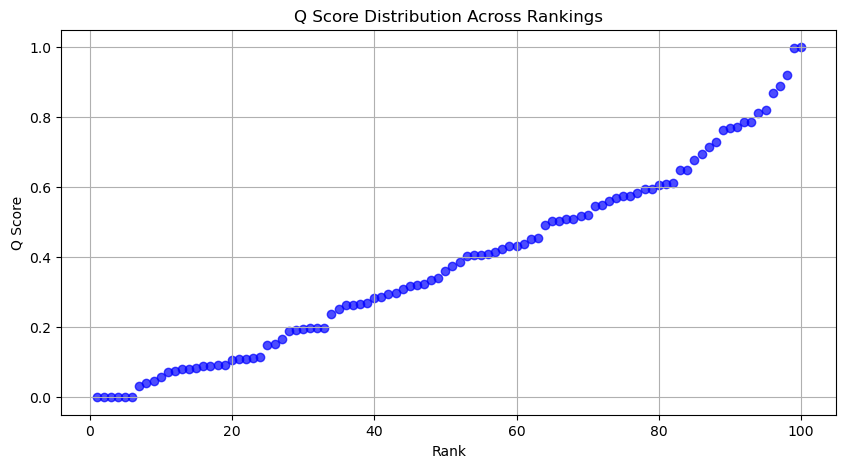

In [363]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(df["Rank"], df["Q"], color="blue", alpha=0.7)
plt.xlabel("Rank")
plt.ylabel("Q Score")
plt.title("Q Score Distribution Across Rankings")
plt.grid(True)
plt.show()

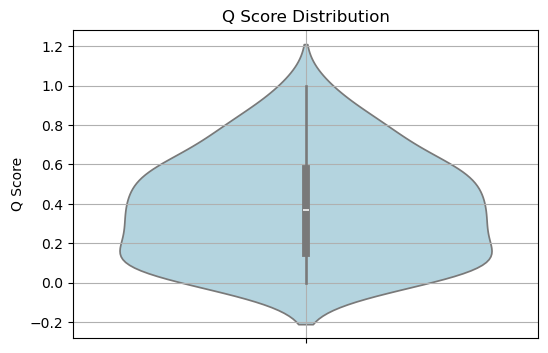

In [361]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.violinplot(y=df["Q"], color="lightblue")
plt.ylabel("Q Score")
plt.title("Q Score Distribution")
plt.grid(True)
plt.show()

In [341]:
# Step 1: Compute IFAHP weights
weights = compute_ifahp_weights(if_matrix)
df["Weight"] = [w[0] for w in weights]  # Use lower bound of weights

# Step 2: Prepare decision matrix (crisp values from Value column)
decision_matrix = df["Value"].values.reshape(-1, 1)  # Use Value as the decision criterion

# Step 3: Apply VIKOR to rank requirements
Q, rankings = apply_vikor(decision_matrix, np.array([w[0] for w in weights]))

# Step 4: Store Q values
df["Q"] = Q  

# Step 5: Ensure proper ranking (sorting by Q)
df = df.sort_values(by="Q", ascending=True).reset_index(drop=True)
df["Rank"] = range(1, len(df) + 1)  # Assign ranks from 1 to N

# Display the final ranked requirements including Q values
print(df[["Req ID", "Req Name", "Weight", "Q", "Rank"]])

    Req ID                Req Name    Weight      Q  Rank
0      101                     URL  0.011436  0.000     1
1      133             Book Ticket  0.010469  0.000     2
2      192                  Offers  0.011544  0.000     3
3      127            Select Movie  0.008270  0.000     4
4      125          BookMyShow App  0.011651  0.000     5
..     ...                     ...       ...    ...   ...
95     181             Sport Venue  0.009394  0.875    96
96     102     Choose Region Modal  0.006940  0.875    97
97     115           Customer Care  0.011907  0.875    98
98     109  Continue with Facebook  0.011866  1.000    99
99     170             Event Terms  0.010254  1.000   100

[100 rows x 5 columns]


In [367]:
# Step 3: Compute IFAHP weights and apply VIKOR through the pipeline
df["Q"], rankings, weights = ifahp_vikor_pipeline(if_matrix, df["Value"].values.reshape(-1, 1))

# Step 4: Store IFAHP weights
df["Weight"] = [w[0] for w in weights]  # Use lower bound of weights

# Step 5: Ensure proper ranking (sorting by Q)
df = df.sort_values(by="Q", ascending=True).reset_index(drop=True)
df["Rank"] = range(1, len(df) + 1)  # Assign ranks from 1 to N

# Debug Output
print("Final Ranked Data:\n", df[["Req ID","Cost","Value","Importance" ,"Weight", "Q", "Rank"]])

Final Ranked Data:
     Req ID  Cost  Value Importance    Weight         Q  Rank
0      101     8      9          H  0.011436  0.000000     1
1      133     4      9          H  0.010469  0.000000     2
2      192     6      9          H  0.011544  0.000000     3
3      127     6      9          H  0.008270  0.000000     4
4      125     5      9          H  0.011651  0.000000     5
..     ...   ...    ...        ...       ...       ...   ...
95     181     4      2          M  0.011866  0.901961    96
96     165     5      3          H  0.014123  0.920168    97
97     182     3      2          L  0.011907  0.922819    98
98     117     3      2          L  0.012618  0.959150    99
99     115     7      2          L  0.013156  1.000000   100

[100 rows x 7 columns]


In [359]:
df["Q"].value_counts()

Q
0.000000    6
0.785382    2
0.430866    2
0.262926    2
0.196505    2
           ..
0.269909    1
0.267354    1
0.251583    1
0.236358    1
1.000000    1
Name: count, Length: 89, dtype: int64